<a href="https://colab.research.google.com/github/gitNinja21/notebooks/blob/main/stockprediction_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math,numpy as np,pandas as pd,matplotlib.pyplot as plt
#%matplotlib inline
import datetime
import seaborn as sns
import itertools
import random
import os,pdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pickle import dump,load
import warnings
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import logging
from sklearn import metrics
from keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
from datetime import datetime, timedelta
import calendar
import matplotlib.ticker as ticker
import scipy.cluster.hierarchy as hc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
logger = logging.getLogger('mylogger')



In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install -Uqq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.0 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kerastuner

In [ ]:
from kerastuner.tuners import RandomSearch,BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
import config as cf


<ipython-input-5-a7ede84c9286>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch,BayesianOptimization


In [ ]:
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
class lstm():
    def __init__(self,**kwargs):
        self.df=kwargs.get('data','')
        self.target_var=kwargs['target_var']
        self.input_var=kwargs['input_var']
        self.extra_var=kwargs['extravar']
        #self._shift=kwargs['shift']
        self._tune_param=kwargs['tune_param']
        self._N=kwargs['cross_val_sample']
        self.random=kwargs.get('random',False)
        self.model_name='model_'+self.input_var[0].replace(" ", "")+'_.h5'
        #self.direction=kwargs['direction']
        self._scaling()
        self._train_test()
        self._tuning()
        #self._result_plot()
        #self._r2_random_samples()



    def _scaling(self):
        logger.info('Normalising the File')
        self.df=concat([self.df[self.input_var],self.df[self.target_var]],axis=1)
        values = self.df.values
        values = values.astype('float32')
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled = scaler.fit_transform(values)
        self.scaled_values=scaled

    def array_to_df(self,scaled):
        df = pd.DataFrame(scaled)
        df.columns=self.input_var+self.target_var
        return df



    def _train_test(self):
        logger.info('creating train test split')
        #ipdb.set_trace(context=6)
        df=self.array_to_df(self.scaled_values)
        if not self.random:
          print("Time series splitting.....")
          train_val_reframed, test_reframed= np.split(df, [int(.9 *len(df))])
        else:
          train_val_reframed, test_reframed = train_test_split(df, test_size=0.1)


        if not self.random:
          train_reframed, val_reframed= np.split(train_val_reframed, [int(.8 *len(train_val_reframed))])
        else:
          train_reframed, val_reframed = train_test_split(train_val_reframed, test_size=0.2)


        self.train_reframed=train_reframed
        self.val_reframed=val_reframed
        self.test_reframed=test_reframed

        train = train_reframed[self.input_var + self.target_var].values
        val = val_reframed[self.input_var + self.target_var].values
        test=test_reframed[self.input_var + self.target_var].values
        # split into input and outputs
        trainX, trainY = train[:, :-1], train[:, -1]
        print(trainX)
        print(trainY)
        valX, valY = val[:, :-1], val[:, -1]
        testX, testY = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        self._test_crossval=test_reframed
        self._trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
        self._testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
        self._valX= valX.reshape((valX.shape[0], 1, valX.shape[1]))

        self._trainY=trainY.reshape(-1,1)
        self._valY=valY.reshape(-1,1)
        self._testY=testY.reshape(-1,1)



    '''
    def _build_model(self,hp):
        regressor = Sequential()
        regressor.add(Bidirectional(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(self._trainX.shape[1],self._trainX.shape[2]))))
        for i in range(hp.Int('n_layers', 1, 4)):
            regressor.add(Bidirectional(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True)))
        regressor.add(Bidirectional(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32))))
        regressor.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
        regressor.add(Dense(self._trainY.shape[1], activation=hp.Choice('dense_activation',values=['relu','tanh'],default='relu')))
        regressor.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
        return regressor

    '''

    def _build_model(self,hp):
        regressor = Sequential()
        regressor.add((LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(self._trainX.shape[1],self._trainX.shape[2]))))
        for i in range(hp.Int('n_layers', 1, 4)):
            regressor.add((LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True)))
        regressor.add((LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32))))
        regressor.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
        regressor.add(Dense(self._trainY.shape[1], activation=hp.Choice('dense_activation',values=['relu','tanh'],default='relu')))
        regressor.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
        return regressor



    def _tuning(self):
        logger.info('Tuning the model')
        tuner= BayesianOptimization(
            self._build_model,
            objective='mse',
            max_trials=self._tune_param['max_trials'],
            overwrite=True,
            executions_per_trial=1
         )
        tuner.search(
        x=self._trainX,
        y=self._trainY,
        epochs=self._tune_param['epoch'],
        batch_size=self._tune_param['batch_size'],
        validation_data=(self._valX,self._valY),
        )
        self._best_model=tuner.get_best_models(num_models=1)[0]


    def _return_plot(self):
      #ipdb.set_trace(context=6)
      testdata=self.test_reframed
      pred = np.where(self._best_model.predict(self._testX) > 0.5, 1, 0)

      testdata['prediction'] = np.where(pred > 0, 1, -1)
      testdata['strategy'] = (testdata['prediction'] *testdata['return'])
      testdata[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))




    def _result_plot(self):
        logger.info('creating results and plot')

        prediction=self._best_model.predict(self._testX)
        pred_list=prediction.tolist()
        pred_flatten=[item for sublist in pred_list for item in sublist]

        act_list=self._testY.tolist().pop(0)+[np.nan]
        act_flatten=[item for sublist in act_list for item in sublist]


        result = pd.DataFrame(
             {'Actual': act_flatten,
             'Predicted': pred_flatten,
             })

        self._result=result
        self._r2= metrics.r2_score(act_flatten, pred_flatten)


        self._best_model.save(self.model_name)  # creates a HDF5 file 'my_model.h5'


        #model = load_model('my_model_1st.h5')

        result.plot()



    def _r2_random_samples(self):
        r2=[]
        N=self._N
        for i in range(N):
            _, test_crossval = train_test_split(self._test_crossval, test_size=0.5)
            test=test_crossval.values
            # split into input and outputs
            testX, testY = test[:, :-1], test[:, -1]
            # reshape input to be 3D [samples, timesteps, features]
            testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
            testY=testY.reshape(-1,1)
            prediction=self._best_model.predict(testX)
            pred_list=prediction.tolist()
            pred_flatten=[item for sublist in pred_list for item in sublist]
            act_list=testY.tolist()
            act_flatten=[item for sublist in act_list for item in sublist]
            r2.append(metrics.r2_score(act_flatten, pred_flatten))
            r2_df=DataFrame(r2,columns=['r2_on_diff_samples'])
            r2_df.plot()


In [ ]:
sector_ht='Healthcare'
sector_energy='Oil Gas & Consumable Fuels'
sector_it='Information Technology'
stocks_ht=[item +'.NS' for item in cf.nifty_world[sector_ht]]
stocks_en=[item +'.NS' for item in cf.nifty_world[sector_energy]]
stocks_it=[item +'.NS' for item in cf.nifty_world[sector_it]]

In [ ]:

start_date = '2003-01-01'
end_date = '2023-07-14'

df=yf.download('BIOCON.NS', start=start_date, end=end_date)[['Adj Close','Volume']]
df=df.dropna().reset_index()



[*********************100%***********************]  1 of 1 completed


In [ ]:
df

,Date,Adj Close,Volume
0,2004-04-07,34.717308,57671472
1,2004-04-08,41.663639,85470720
2,2004-04-09,41.663639,0
3,2004-04-12,49.886627,47399796
4,2004-04-13,44.618599,117545316
...,...,...,...
4760,2023-07-07,253.949997,2992725
4761,2023-07-10,254.699997,3929446
4762,2023-07-11,254.199997,2604446
4763,2023-07-12,259.149994,4526585


In [ ]:
def individual_stock(df):
    return pd.DataFrame({'Date': df['Date'], 'Close': df['Adj Close'], 'Volume': df['Volume']})

def trading_window(data,w):
  #data['return'] = np.log(data['Close'] /data['Close'].shift(1))
  #data['direction'] = np.where(data['return'] > 0, 1, 0)
  lags = w
  cols = []
  for lag in range(1, lags + 1):
    col = f'lag_close_{lag}'
    data[col] = data['Close'].shift(lag)
    cols.append(col)
  #data.dropna(inplace=True)

  for lag in range(1, lags + 1):
    col = f'lag_vol_{lag}'
    data[col] = data['Volume'].shift(lag)
    cols.append(col)
  #data.dropna(inplace=True)

  modelling_cols=['Close']+cols
  return data[modelling_cols]

In [ ]:
stock_data=individual_stock(df)
stock_data


,Date,Close,Volume
0,2004-04-07,34.717308,57671472
1,2004-04-08,41.663639,85470720
2,2004-04-09,41.663639,0
3,2004-04-12,49.886627,47399796
4,2004-04-13,44.618599,117545316
...,...,...,...
4760,2023-07-07,253.949997,2992725
4761,2023-07-10,254.699997,3929446
4762,2023-07-11,254.199997,2604446
4763,2023-07-12,259.149994,4526585


In [ ]:
trading_window(stock_data,10)

,Close,lag_close_1,lag_close_2,lag_close_3,lag_close_4,lag_close_5,lag_close_6,lag_close_7,lag_close_8,lag_close_9,...,lag_vol_1,lag_vol_2,lag_vol_3,lag_vol_4,lag_vol_5,lag_vol_6,lag_vol_7,lag_vol_8,lag_vol_9,lag_vol_10
0,34.717308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,41.663639,34.717308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57671472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,41.663639,41.663639,34.717308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85470720.0,57671472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,49.886627,41.663639,41.663639,34.717308,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,85470720.0,57671472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,44.618599,49.886627,41.663639,41.663639,34.717308,NaN,NaN,NaN,NaN,NaN,...,47399796.0,0.0,85470720.0,57671472.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,253.949997,258.000000,254.669357,259.512665,260.451691,262.428558,240.831314,240.831314,237.174133,234.159409,...,3801171.0,3783626.0,6335870.0,5176929.0,18396181.0,0.0,2772073.0,2646456.0,1917570.0,2270480.0
4761,254.699997,253.949997,258.000000,254.669357,259.512665,260.451691,262.428558,240.831314,240.831314,237.174133,...,2992725.0,3801171.0,3783626.0,6335870.0,5176929.0,18396181.0,0.0,2772073.0,2646456.0,1917570.0
4762,254.199997,254.699997,253.949997,258.000000,254.669357,259.512665,260.451691,262.428558,240.831314,240.831314,...,3929446.0,2992725.0,3801171.0,3783626.0,6335870.0,5176929.0,18396181.0,0.0,2772073.0,2646456.0
4763,259.149994,254.199997,254.699997,253.949997,258.000000,254.669357,259.512665,260.451691,262.428558,240.831314,...,2604446.0,3929446.0,2992725.0,3801171.0,3783626.0,6335870.0,5176929.0,18396181.0,0.0,2772073.0


In [ ]:
modelling_data=trading_window(stock_data,10).dropna()


In [ ]:
modelling_data.columns

Index(['Close', 'lag_close_1', 'lag_close_2', 'lag_close_3', 'lag_close_4',
       'lag_close_5', 'lag_close_6', 'lag_close_7', 'lag_close_8',
       'lag_close_9', 'lag_close_10', 'lag_vol_1', 'lag_vol_2', 'lag_vol_3',
       'lag_vol_4', 'lag_vol_5', 'lag_vol_6', 'lag_vol_7', 'lag_vol_8',
       'lag_vol_9', 'lag_vol_10'],
      dtype='object')

In [ ]:
tune_param={'epoch':120,
                'batch_size':64,
                'max_trials':2}
target_var=['Close']
inputvar=['lag_close_1', 'lag_close_2', 'lag_close_3', 'lag_close_4',
       'lag_close_5', 'lag_close_6', 'lag_close_7', 'lag_close_8',
       'lag_close_9', 'lag_close_10', 'lag_vol_1', 'lag_vol_2', 'lag_vol_3',
       'lag_vol_4', 'lag_vol_5', 'lag_vol_6', 'lag_vol_7', 'lag_vol_8',
       'lag_vol_9', 'lag_vol_10']
extravar=['']

engine=lstm(data=modelling_data,target_var=target_var,input_var=inputvar,tune_param=tune_param,cross_val_sample=10,extravar=extravar)

Trial 2 Complete [00h 08m 34s]
mse: 0.6668002605438232

Best mse So Far: 0.0003143318463116884
Total elapsed time: 00h 16m 10s


In [ ]:
prediction=engine._best_model.predict(engine._testX)
pred_list=prediction.tolist()
pred_flatten=[item for sublist in pred_list for item in sublist]
#pred_flatten=pred_flatten[1:]+[np.nan]

act_list=engine._testY.tolist()
act_flatten=[item for sublist in act_list for item in sublist]


result = pd.DataFrame(
      {'Actual': act_flatten,
      'Predicted': pred_flatten,
      })

engine._result=result
#engine._r2= metrics.r2_score(act_flatten, pred_flatten)


#engine._best_model.save('biocon.h5')  # creates a HDF5 file 'my_model.h5'


#model = load_model('my_model_1st.h5')

result.plot(grid=True,style='.-')

In [ ]:
#newdata
start_date = '2023-03-01'
end_date = '2023-07-15'

df_new=yf.download('BIOCON.NS', start=start_date, end=end_date)[['Adj Close','Volume']]
df_new=df_new.dropna().reset_index()

[*********************100%***********************]  1 of 1 completed


In [ ]:
df_new

,Date,Adj Close,Volume
0,2023-03-01,224.522202,3583078
1,2023-03-02,220.914444,5807866
2,2023-03-03,222.940735,3976008
3,2023-03-06,223.780884,4048944
4,2023-03-08,221.013290,4032570
...,...,...,...
86,2023-07-10,254.699997,3929446
87,2023-07-11,254.199997,2604446
88,2023-07-12,259.149994,4526585
89,2023-07-13,257.149994,2780982


In [ ]:
newdata=individual_stock(df_new)
newdata=trading_window(newdata,10)
#newdata=newdata.dropna()

In [ ]:
newdata=newdata.dropna()
newdata

,Close,lag_close_1,lag_close_2,lag_close_3,lag_close_4,lag_close_5,lag_close_6,lag_close_7,lag_close_8,lag_close_9,...,lag_vol_1,lag_vol_2,lag_vol_3,lag_vol_4,lag_vol_5,lag_vol_6,lag_vol_7,lag_vol_8,lag_vol_9,lag_vol_10
10,219.283539,218.690460,215.280380,215.626312,221.161545,221.260391,221.013290,223.780884,222.940735,220.914444,...,2460149.0,1694587.0,2406396.0,3829349.0,3943009.0,4032570.0,4048944.0,3976008.0,5807866.0,3583078.0
11,199.959702,219.283539,218.690460,215.280380,215.626312,221.161545,221.260391,221.013290,223.780884,222.940735,...,2654387.0,2460149.0,1694587.0,2406396.0,3829349.0,3943009.0,4032570.0,4048944.0,3976008.0,5807866.0
12,199.416046,199.959702,219.283539,218.690460,215.280380,215.626312,221.161545,221.260391,221.013290,223.780884,...,43622635.0,2654387.0,2460149.0,1694587.0,2406396.0,3829349.0,3943009.0,4032570.0,4048944.0,3976008.0
13,198.773575,199.416046,199.959702,219.283539,218.690460,215.280380,215.626312,221.161545,221.260391,221.013290,...,12777914.0,43622635.0,2654387.0,2460149.0,1694587.0,2406396.0,3829349.0,3943009.0,4032570.0,4048944.0
14,201.343491,198.773575,199.416046,199.959702,219.283539,218.690460,215.280380,215.626312,221.161545,221.260391,...,12170982.0,12777914.0,43622635.0,2654387.0,2460149.0,1694587.0,2406396.0,3829349.0,3943009.0,4032570.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,254.699997,253.949997,258.000000,254.669357,259.512665,260.451691,262.428558,240.831329,240.831329,237.174133,...,2992725.0,3801171.0,3783626.0,6335870.0,5176929.0,18396181.0,0.0,2772073.0,2646456.0,1917570.0
87,254.199997,254.699997,253.949997,258.000000,254.669357,259.512665,260.451691,262.428558,240.831329,240.831329,...,3929446.0,2992725.0,3801171.0,3783626.0,6335870.0,5176929.0,18396181.0,0.0,2772073.0,2646456.0
88,259.149994,254.199997,254.699997,253.949997,258.000000,254.669357,259.512665,260.451691,262.428558,240.831329,...,2604446.0,3929446.0,2992725.0,3801171.0,3783626.0,6335870.0,5176929.0,18396181.0,0.0,2772073.0
89,257.149994,259.149994,254.199997,254.699997,253.949997,258.000000,254.669357,259.512665,260.451691,262.428558,...,4526585.0,2604446.0,3929446.0,2992725.0,3801171.0,3783626.0,6335870.0,5176929.0,18396181.0,0.0


In [ ]:
#new precition
#df.tail()
model = load_model('biocon.h5')



#scaling
newdata=concat([newdata[engine.input_var],newdata[engine.target_var]],axis=1)
values = newdata.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled_df=engine.array_to_df(scaled)




OSError: ignored

> /usr/local/lib/python3.10/dist-packages/keras/saving/legacy/save.py(230)load_model()
    228                     if isinstance(filepath_str, str):
    229                         if not tf.io.gfile.exists(filepath_str):
--> 230                             raise IOError(
    231                                 f"No file or directory found at {filepath_str}"
    232                             )



In [ ]:
scaled_df=scaled_df.values
newX, newY = scaled_df[:, :-1], scaled_df[:, -1]
newX= newX.reshape((newX.shape[0], 1, newX.shape[1]))
newY=newY.reshape(-1,1)


3/3 [==============================] - 0s 9ms/step


<Axes: >

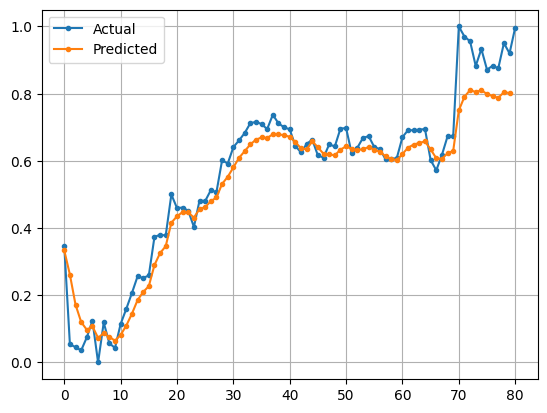

In [ ]:
prediction=model.predict(newX)
pred_list=prediction.tolist()
pred_flatten=[item for sublist in pred_list for item in sublist]
pred_flatten=pred_flatten[1:]+[np.nan]
act_list=newY.tolist()
act_flatten=[item for sublist in act_list for item in sublist]


result = pd.DataFrame(
      {'Actual': act_flatten,
      'Predicted': pred_flatten,
      })

#engine._result=result
#engine._r2= metrics.r2_score(act_flatten, pred_flatten)


#engine._best_model.save('biocon.h5')  # creates a HDF5 file 'my_model.h5'


#model = load_model('my_model_1st.h5')

result.plot(grid=True,style='.-')

In [ ]:
result

,Actual,Predicted
0,1.000000,0.906361
1,0.951680,0.891353
2,0.883913,0.859697
3,0.908073,0.812663
4,0.905716,0.829500
...,...,...
148,0.695121,0.656745
149,0.689159,0.664677
150,0.748180,0.659158
151,0.724333,0.709037


In [ ]:
%pdb off

Automatic pdb calling has been turned OFF
